In [1]:
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import os
import ipaddress
from aimlsse_api.client import GroundDataClient, SatelliteDataClient

In [2]:
ground_data_client = GroundDataClient(ipaddress.ip_address('127.0.0.1'), 8000)

In [3]:
ground_data = ground_data_client.queryMeasurements(datetime.datetime(2022, 11, 10), datetime.datetime(2022, 12, 20))
print(ground_data)

                         geometry        date   latitude   longitude  \
0       POINT (-97.75289 1.19022)  2022-11-11   1.190224  -97.752886   
1      POINT (-15.53924 77.51074)  2022-11-11  77.510742  -15.539237   
2     POINT (-178.81173 57.98357)  2022-11-11  57.983572 -178.811731   
3     POINT (107.67412 -37.78520)  2022-11-11 -37.785202  107.674122   
4       POINT (-76.35861 4.65322)  2022-11-11   4.653225  -76.358613   
..                            ...         ...        ...         ...   
247  POINT (-154.14554 -28.53054)  2022-12-01 -28.530543 -154.145537   
248     POINT (27.27899 19.90199)  2022-12-01  19.901985   27.278988   
249     POINT (71.63926 66.36344)  2022-12-01  66.363442   71.639263   
250      POINT (35.66649 4.68995)  2022-12-01   4.689949   35.666487   
251   POINT (-65.69134 -48.00498)  2022-12-01 -48.004978  -65.691344   

     temperature  
0       8.154448  
1     -19.432827  
2      26.654849  
3      36.954207  
4      34.601731  
..           ...  
24

In [4]:
locations = ground_data.drop_duplicates('geometry')
locations = locations[['longitude', 'latitude', 'geometry']]
print(len(locations))
print(locations)

12
     longitude   latitude                      geometry
0   -97.752886   1.190224     POINT (-97.75289 1.19022)
1   -15.539237  77.510742    POINT (-15.53924 77.51074)
2  -178.811731  57.983572   POINT (-178.81173 57.98357)
3   107.674122 -37.785202   POINT (107.67412 -37.78520)
4   -76.358613   4.653225     POINT (-76.35861 4.65322)
5    56.393806  42.480052     POINT (56.39381 42.48005)
6   163.953316 -16.855733   POINT (163.95332 -16.85573)
7  -154.145537 -28.530543  POINT (-154.14554 -28.53054)
8    27.278988  19.901985     POINT (27.27899 19.90199)
9    71.639263  66.363442     POINT (71.63926 66.36344)
10   35.666487   4.689949      POINT (35.66649 4.68995)
11  -65.691344 -48.004978   POINT (-65.69134 -48.00498)


In [5]:
satellite_data_client = SatelliteDataClient(ipaddress.ip_address('127.0.0.1'), 8001)

In [6]:
grid_cells = satellite_data_client.queryContainingGeometry(locations)
print(grid_cells)

                                             geometry   Name  \
0   GEOMETRYCOLLECTION Z (POLYGON Z ((180.00000 57...  01VCE   
1   GEOMETRYCOLLECTION Z (POLYGON Z ((-155.03407 -...  05JLJ   
2   GEOMETRYCOLLECTION Z (POLYGON Z ((-98.10092 1....  14NPG   
3   GEOMETRYCOLLECTION Z (POLYGON Z ((-76.80509 5....  18NUL   
4   GEOMETRYCOLLECTION Z (POLYGON Z ((-66.32849 -4...  19FGG   
5   GEOMETRYCOLLECTION Z (POLYGON Z ((-19.43778 78...  28XDM   
6   GEOMETRYCOLLECTION Z (POLYGON Z ((26.99981 20....  35QNC   
7   GEOMETRYCOLLECTION Z (POLYGON Z ((34.80473 5.4...  36NYL   
8   GEOMETRYCOLLECTION Z (POLYGON Z ((55.76569 43....  40TDN   
9   GEOMETRYCOLLECTION Z (POLYGON Z ((71.26621 66....  42WXU   
10  GEOMETRYCOLLECTION Z (POLYGON Z ((107.24791 -3...  48HYD   
11  GEOMETRYCOLLECTION Z (POLYGON Z ((107.62871 -3...  49HBU   
12  GEOMETRYCOLLECTION Z (POLYGON Z ((163.12842 -1...  58KCG   

                                          Description  
0   TILE PROPERTIES<br><table border=0 cellpadd

In [7]:
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

In [8]:
output_dir = 'results/'
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

C:\Users\erikw\AppData\Local\Temp\ipykernel_30488\2206605534.py:5: UserWarning: You passed a edgecolor/edgecolors ('white') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(locations.longitude, locations.latitude, marker='x', s=10, linewidth=0.5, color='#E74C3C', edgecolor='white', zorder=3)


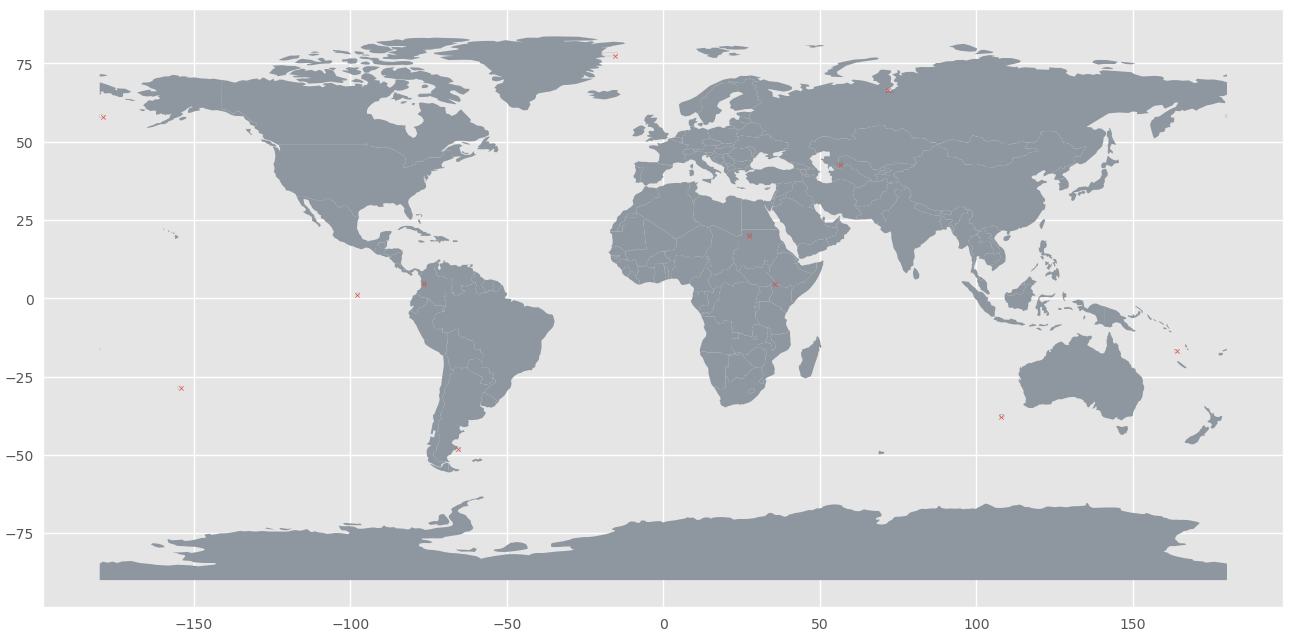

In [9]:
with plt.style.context(("seaborn", "ggplot")):
    world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
    ax = world.plot(figsize=(16,9), color='#8e979f', zorder=1);
    grid_cells.buffer(0).boundary.plot(ax=ax, edgecolor='black', alpha=0.6, linewidth=0.1, zorder=2)
    ax.scatter(locations.longitude, locations.latitude, marker='x', s=10, linewidth=0.5, color='#E74C3C', edgecolor='white', zorder=3)
    plt.savefig(f'{output_dir}locations_and_grid_cells_view.svg', bbox_inches='tight', dpi=150, format='svg')